# SARIMA(p,d,q)(P,D,Q,m): Seasonal Autoregressive Integrated Moving Averages
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an `additional` set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from pylab import rcParams

rcParams['figure.figsize'] = 20, 6
rcParams['axes.grid'] = True

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string(), '\n')          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    return out

In [4]:
df = pd.read_csv('../meta/co2_mm_mlo.csv')
df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
df.set_index('date',inplace=True)
df.index.freq = 'MS'
print(len(df))
df.head()

729


,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


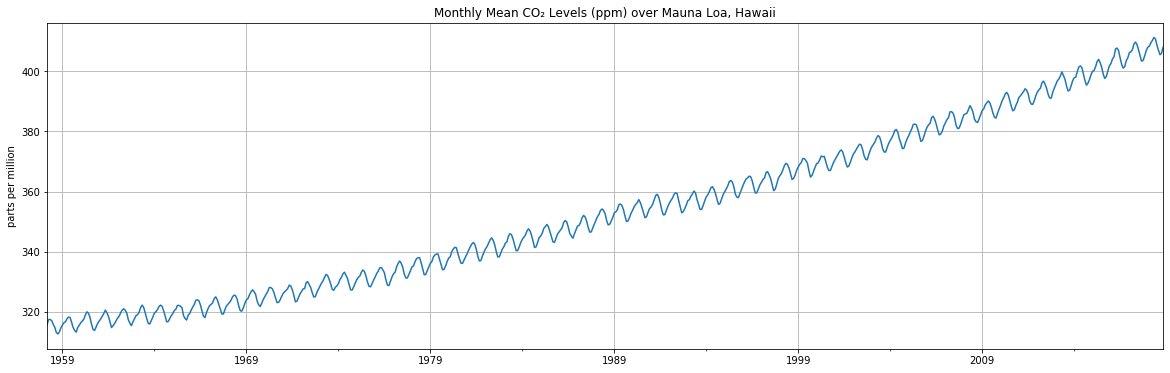

In [5]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot()
ax.set(xlabel=xlabel, ylabel=ylabel, title=title);

**ETS Decomposition**

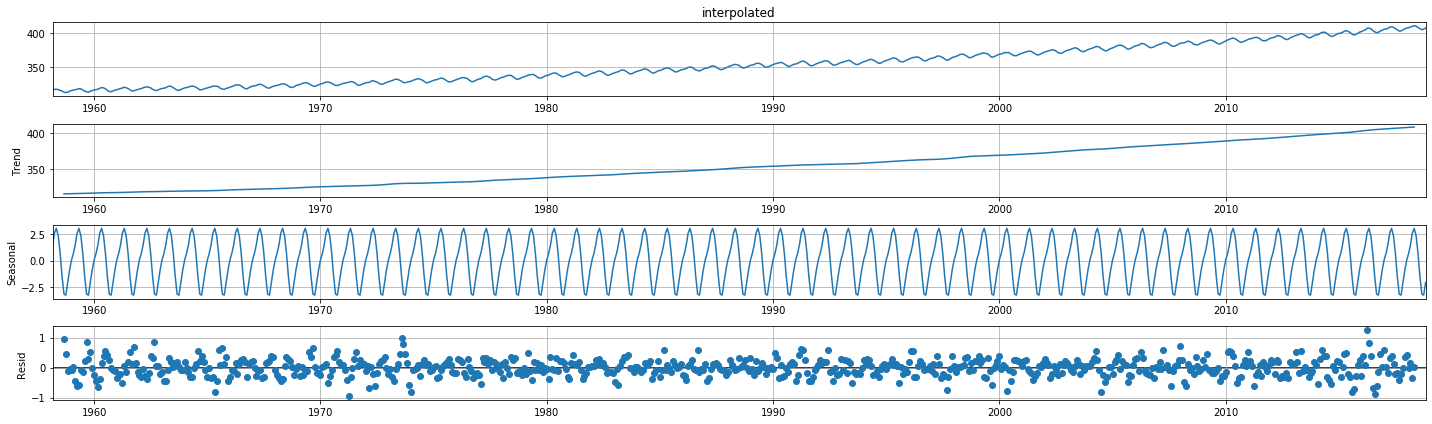

In [6]:
seasonal_decompose(df['interpolated'], model='add').plot();

Although small in scale compared to the overall values, there is a definite annual seasonality.

In [7]:
from pmdarima import auto_arima      

auto_arima(df['interpolated'], seasonal=True, m=12, suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -206.252
Date:                            Mon, 02 Nov 2020   AIC                            424.504
Time:                                    20:22:03   BIC                            452.046
Sample:                                         0   HQIC                           435.131
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3513      0.094      3.738      0.000       0.167       0.536
ar.L2          0.0875      0.052      1.680      0.093      -0.015       0.190
ma.L1         -0.7067      0.088     -7.992      0.000      -0.880      -0.533
ar.S.L12       0.9996      0.000   2896.285      0.000       0.999       1.000
ma.S.L12      -0.8664      0.021    -40.599      0.000      -0.908      -0.825
sigma2         0.0957      0.005     20.580      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       43.73   Jarque-Bera (JB):                 4.47
Prob(Q):                              0.32   Prob(JB):                         0.11
Heteroskedasticity (H):               1.13   Skew:                            -0.00
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Split the Data**

In [8]:
train = df.iloc[:717]
test = df.iloc[717:]

start=len(train)
end=len(train)+len(test)-1

**Training and Evaluation**

In [9]:
model = SARIMAX(train['interpolated'],order=(2, 1, 1),seasonal_order=(1,0,1,12)).fit()
predictions = model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2, 1, 1)(1,0,1,12) Predictions')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -201.887
Date:                            Mon, 02 Nov 2020   AIC                            415.774
Time:                                    20:22:06   BIC                            443.217
Sample:                                03-01-1958   HQIC                           426.371
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3488      0.060      5.831      0.000       0.232       0.466
ar.L2          0.0843      0.025      3.405      0.001       0.036       0.133
ma.L1         -0.7032      0.048    -14.556      0.000      -0.798      -0.609
ar.S.L12       0.9996      0.000   2626.275      0.000       0.999       1.000
ma.S.L12      -0.8649      0.023    -37.698      0.000      -0.910      -0.820
sigma2         0.0953      0.005     20.304      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       44.28   Jarque-Bera (JB):                 4.63
Prob(Q):                              0.30   Prob(JB):                         0.10
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

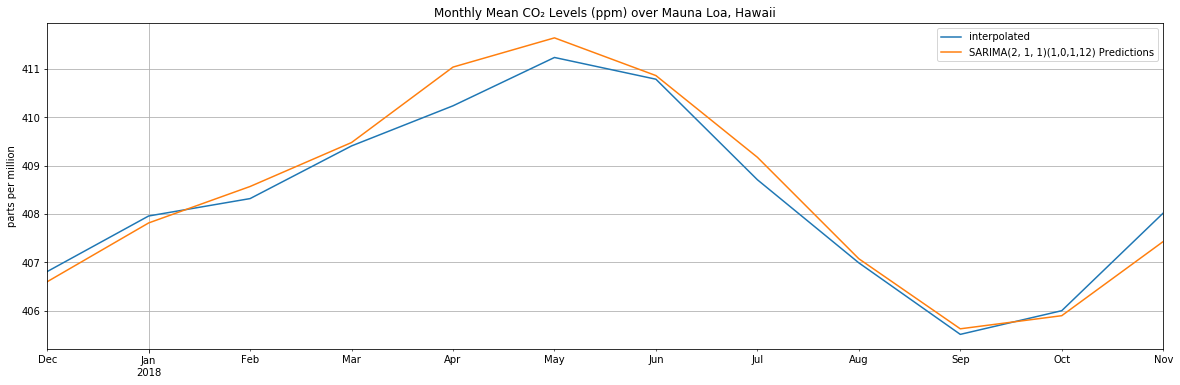

In [10]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True)
predictions.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel, title=title);

**Forecasting**

In [11]:
model = SARIMAX(df['interpolated'],order=(2, 1, 1),seasonal_order=(1,0,1,12)).fit()
fcast = model.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(2, 1, 1)(1,0,1,12) Forecast')

D:\Users\Ritvik\Anaconda3\envs\ailab\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


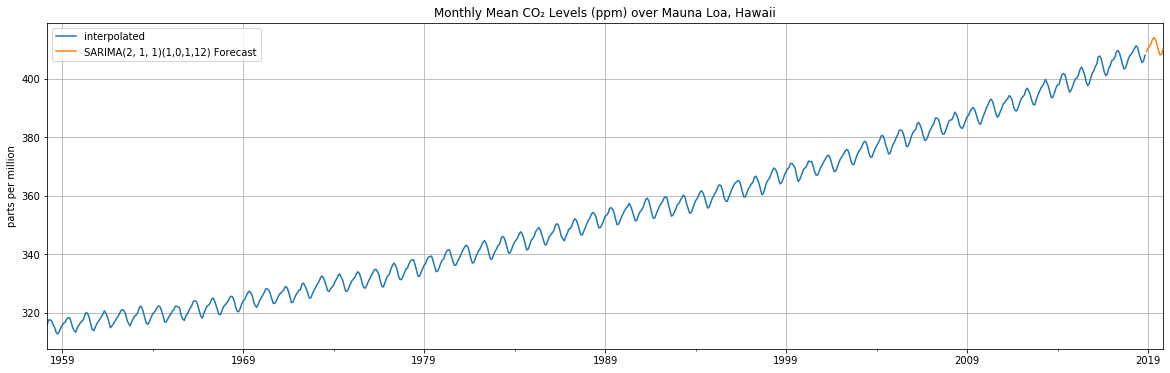

In [12]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True)
fcast.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel, title=title);

# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors

So far the models we've looked at consider past values of a dataset and past errors to determine future trends, seasonality and forecasted values. We look now to models that encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.

In [13]:
df = pd.read_csv('../meta/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

## Inspect the data
For this section we've built a Restaurant Visitors dataset that was inspired by a <a href='https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting'>recent Kaggle competition</a>. The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

In [14]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


Notice that even though the restaurant visitor columns contain integer data, they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.

In [15]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [16]:
df1 = df.dropna()
print(len(df1))
df1.tail()

478


,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [17]:
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


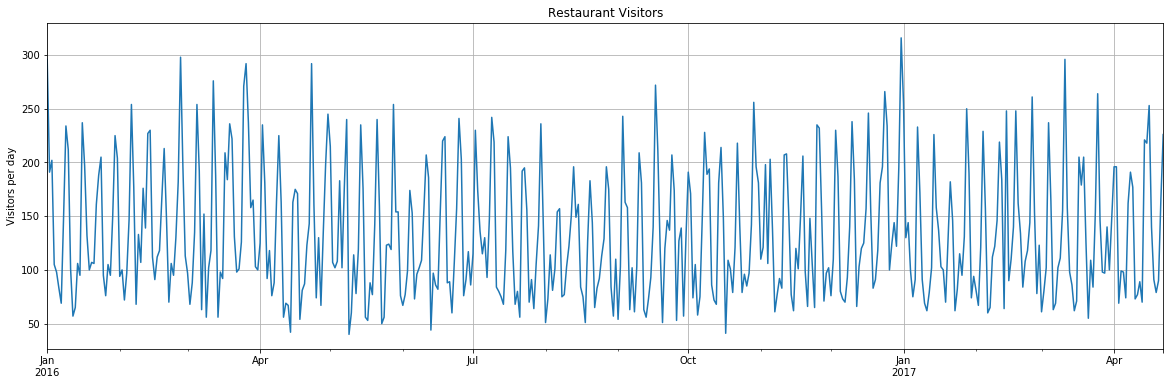

In [18]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot()
ax.set(xlabel=xlabel, ylabel=ylabel, title=title);

## Look at holidays
Rather than prepare a separate plot, we can use matplotlib to shade holidays behind our restaurant data.

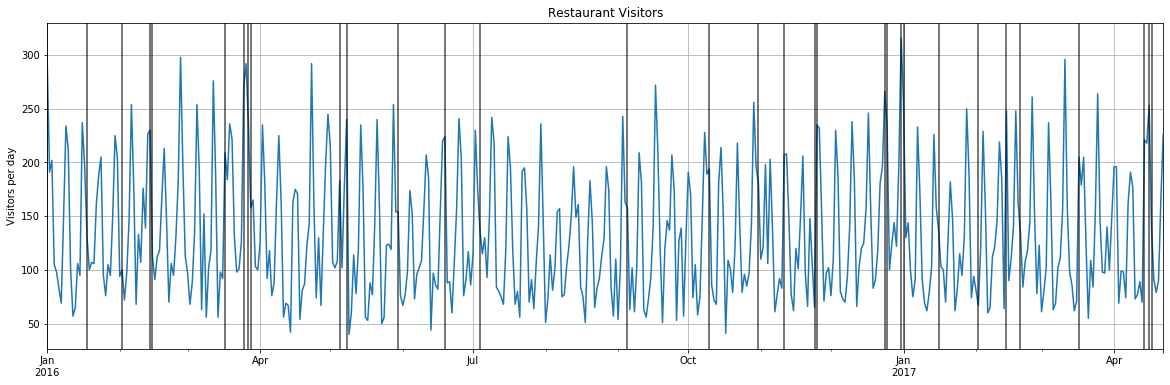

In [19]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' 

ax = df1['total'].plot()
ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.7);  # add a semi-transparent grey line

**ETS Decomposition**

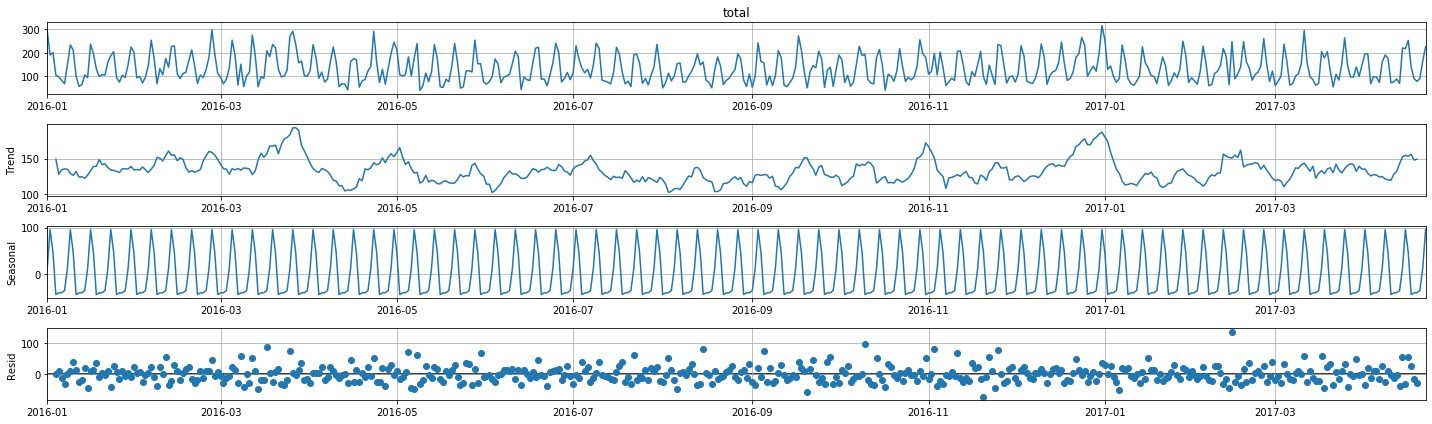

In [20]:
seasonal_decompose(df1['total']).plot();

In [21]:
adf_test(df1['total']);

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135 

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Run `pmdarima.auto_arima`to obtain recommended orders

In [22]:
auto_arima(df1['total'],seasonal=True,m=7, suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2381.236
Date:                   Mon, 02 Nov 2020   AIC                           4770.473
Time:                           20:22:35   BIC                           4787.151
Sample:                                0   HQIC                          4777.030
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9608      1.560      2.539      0.011       0.903       7.019
ar.S.L7        0.9680      0.012     80.844      0.000       0.945       0.991
ma.S.L7       -0.7538      0.050    -15.143      0.000      -0.851      -0.656
sigma2      1242.6075     75.050     16.557      0.000    1095.512    1389.703
===================================================================================
Ljung-Box (Q):                       65.50   Jarque-Bera (JB):                65.29
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.74
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's train & test the SARIMA model, evaluate it, then compare the result to a model that uses an exogenous variabl

In [23]:
train = df1.iloc[:436]
test = df1.iloc[436:]

start=len(train)
end=len(train)+len(test)-1

In [24]:
model = SARIMAX(train['total'],order=(0,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False).fit()
predictions = model.predict(start=start, end=end, dynamic=False).rename('SARIMA(0,0,0)(1,0,1,7) Predictions')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2165.369
Date:                   Mon, 02 Nov 2020   AIC                           4336.738
Time:                           20:22:36   BIC                           4348.970
Sample:                       01-01-2016   HQIC                          4341.565
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9999   9.57e-05   1.05e+04      0.000       1.000       1.000
ma.S.L7       -0.9384      0.024    -39.206      0.000      -0.985      -0.891
sigma2      1111.8057     58.741     18.927      0.000     996.676    1226.935
===================================================================================
Ljung-Box (Q):                       67.58   Jarque-Bera (JB):                83.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.72
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

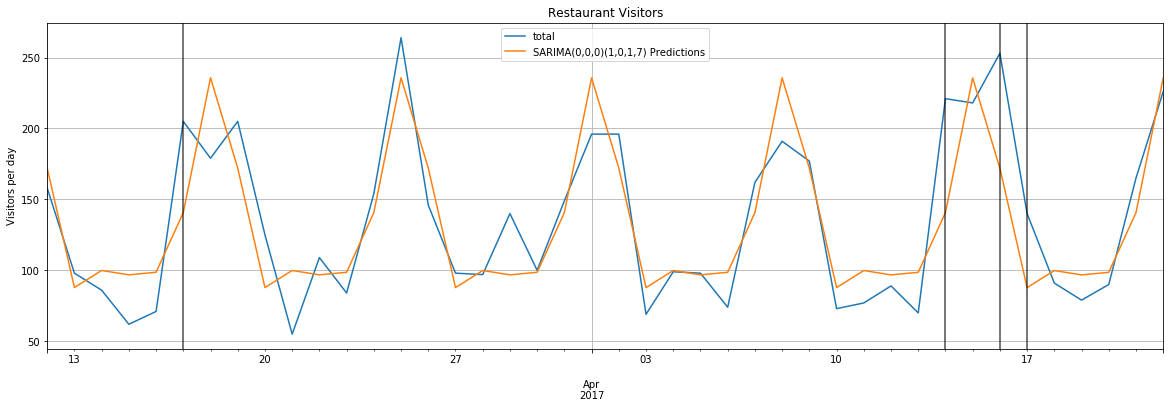

In [25]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True)
predictions.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel ,title=title)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.7);

**Now add the exog variable**

In [26]:
exog_forecast = test[['holiday']]  # requires a shape of (n,1)

model = SARIMAX(train['total'],exog=train['holiday'],order=(0,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False).fit()
predictions = model.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(0,0,0)(1,0,1,7) Predictions')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2098.576
Date:                   Mon, 02 Nov 2020   AIC                           4205.152
Time:                           20:22:37   BIC                           4221.462
Sample:                       01-01-2016   HQIC                          4211.589
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       70.0714      3.972     17.640      0.000      62.286      77.857
ar.S.L7        1.0000   4.74e-05   2.11e+04      0.000       1.000       1.000
ma.S.L7       -0.9556      0.022    -42.738      0.000      -0.999      -0.912
sigma2       809.3932     47.196     17.150      0.000     716.890     901.896
===================================================================================
Ljung-Box (Q):                       56.41   Jarque-Bera (JB):                21.14
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.23
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

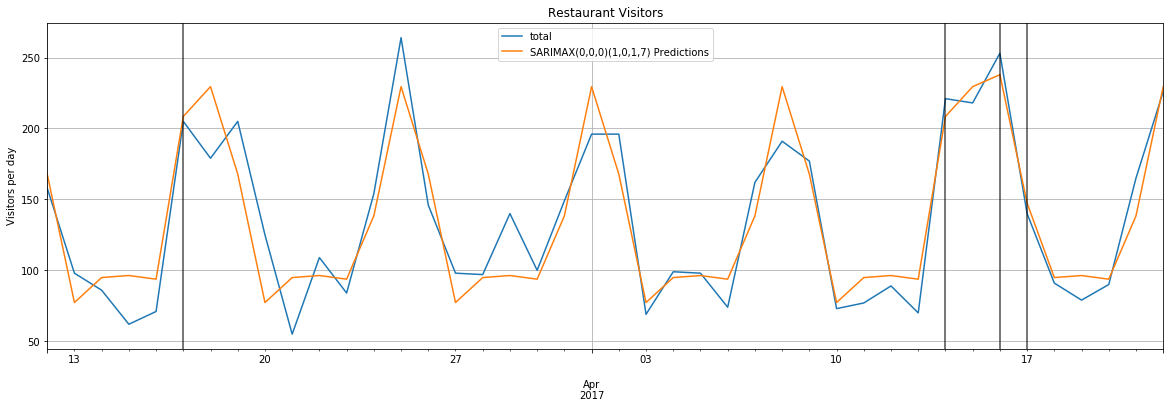

In [27]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True)
predictions.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.7);

**Retrain the model on the full data, and forecast the future**

We're going to forecast 39 days into the future, and use the additional holiday data

In [28]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(0,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False).fit()
exog_forecast = df[478:][['holiday']]
fcast = model.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(0,0,0)(1,0,1,7) Forecast')

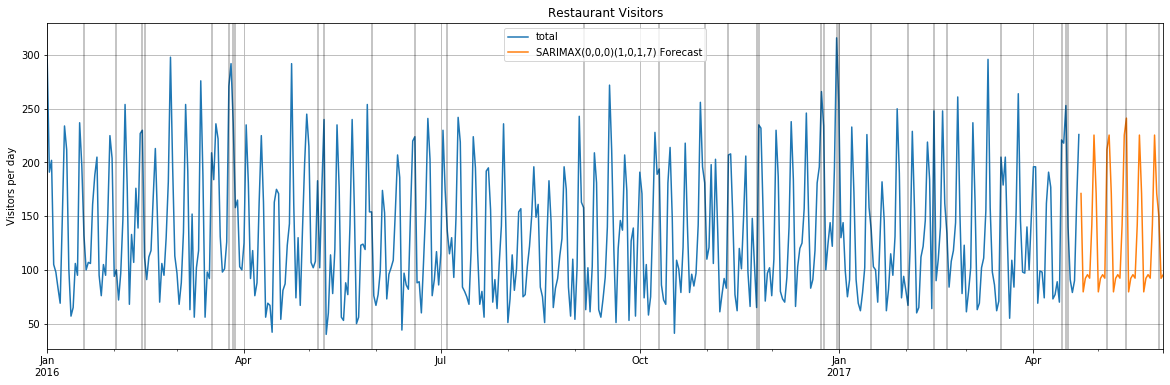

In [29]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True)
fcast.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel,title=title)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);